In [2]:
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F # 内置的激活函数

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

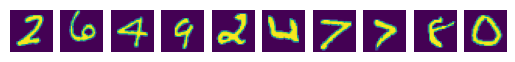

In [3]:
# 下载MNIST数据集
# ToTensor() 规范格式 (channel, height, width)
train_ds = torchvision.datasets.MNIST('./第6章/data',
                                      train=True,
                                      transform=ToTensor(),
                                      download=True)

test_ds = torchvision.datasets.MNIST('./第6章/data',
                                      train=False,
                                      transform=ToTensor(),
                                      download=True)

# 批次管理训练
train_dl = DataLoader(train_ds, batch_size=64,shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

'''
iter(train_dl) 将train_dl转换为可迭代对象
next(iter(train_dl)) 迭代一次
'''
imgs, labels = next(iter(train_dl))

'''
enumerate(sequence, start=0)
sequence 一个序列、迭代器或其他支持迭代对象
start 下标索引开始位置,默认为0
'''
for i, img in enumerate(imgs[:10], start=0): # 前10张图
    img = np.squeeze(img) # 去除维度为1的
    plt.subplot(1, 10, i+1) # 1行10列
    plt.imshow(img) # 画图
    plt.axis('off') # 关闭坐标系

In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        # 输入通道数，输出通道数，卷积核数
        self.conv1 = nn.Conv2d(1, 6, 5) # 卷积层 提取边缘特征
        self.pool = nn.MaxPool2d(2) # 池化层 缩小图像
        self.conv2 = nn.Conv2d(6, 16, 5) # 卷积层
              
        # 输入为前面处理后的值 
        self.linear1 = nn.Linear(16*4*4, 128) # 全连接层
        self.linear2 = nn.Linear(128, 10) # 全连接层
        
    def forward(self, input):
        x = self.pool(F.relu(self.conv1(input)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # 查看暂停后的像素，给全连接层的输入
        # print(x.size()) 
        
        # 根据像素自适应  
        x =  x.view(-1, 16*4*4) # x = x.view(x.size(0), -1) 根据批次自适应
        x = F.relu(self.linear1(x))
        logits = self.linear2(x)       
        return logits

model = Model().to('cuda')   # 初始化模型，放到GPU上

# 交叉熵损失函数(合并了Softmax激活函数)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001) # 随机梯度下降优化器

# model(imgs.to('cuda'))

In [16]:
# 训练函数
def train(dl, model, loss_fn, optimizer):
    size = len(dl.dataset) # 总的个数    
    num_batches = len(dl) # 总批次数 = 总的个数//每批数
        
    train_loss, correct = 0, 0
        
    for x, y in dl:
        x, y = x.to('cuda'), y.to('cuda')
        pred = model(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # pred 第一维是每批数 
            correct += (pred.argmax(1) == y).float().sum().item()
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches
    
    return correct, train_loss

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset)    
    num_batches = len(test_dl)
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to('cuda'), y.to('cuda')
            pred = model(x)         
            loss = loss_fn(pred, y)
            
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).float().sum().item()
        correct /= size
        test_loss /= num_batches
        return correct, test_loss

In [15]:
def fit(epochs,train_dl,test_dl,model, loss_fn, opt):
    # 列表记录每轮的数据
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
        
        # 追加到列表中
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)
        
        # 打印模板
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.1f},test_Loss:{:.5f}, test_acc:{:.1f}")
        
        print(template.format(epoch, epoch_train_loss, epoch_train_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    return train_loss,train_acc,test_loss,test_acc

In [ ]:
epochs = 10
(train_loss,
 train_acc,
 test_loss,
 test_acc) = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, loss_fn=loss_fn, opt=opt)

plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.legend()

plt.plot(range(epochs), train_acc, label='train_acc')
plt.plot(range(epochs), test_acc, label='test_acc')
plt.legend() 